In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [2]:
from initialize_deepbsde_BS_standard import *
Niter = 6000 #Number of epochs
M = 5000 #Number of training examples (number of random paths)
H = 3 #Number of hidden layers for each subneural network
d = 10 #Number of neurons at each hidden layer

t0 is equal to 0.0
T is equal to 1.0
N is equal to 10
xi is equal to 100.0
timestep is equal to 0.1


In [3]:
#Notation for the code:
#t0, t1 ... t_{N}=T
#X_0 = X(t0), X_1 = X(t1), ..., X_N = X(t_N)
#DeltaW_{i} = W_{i+1} - W_{i}
#DeltaW_0, ..., DeltaW_{N-1}
#theta = u_pred(X_0,t_0)
#thetax = ux_pred(X_0,t_0)

#shapeX = N+1
#shapeW = N
#shape(u_pred) = N+1 (including theta) or N (not including theta)
#shape(ux_pred) = N (including thetax) or N-1 (not including thetax)

In [4]:
from randomwalk_deepbsde_mod import randomwalk
#Now we generate M random walks, following the guidelines of the article
#According to the article: 
#W[_,i] = DeltaW_{i} = W_{i+1} - W_{i}
#X[_,i] = X_{i} = X(t_i)
X, W = randomwalk( xi = xi, t0 = t0, T = T, sigma = sigma, mu = mu, M = M, N = N)
W = tf.convert_to_tensor(W, dtype = "float32")
X = tf.convert_to_tensor(X, dtype = "float32")

In [5]:
#We must define a class that defines u(xi,t0) and ux(xi,t0) as weights
#This will be the class that performs the initial forward iteration [u(xi,t0),ux(xi,t0)] -> u(X_1,t_1)
#Forward iteration: u1( X_1,t_1 ) = u(xi,t0) - f(u_0,xi,t0) + ux(xi,t0)*sigma(xi,t0)*W[0]
#We will call u(xi,t0)=theta; ux(xi,t0)=thetax

class initialforwarditeration(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        theta_init = tf.random_uniform_initializer(max(E-xi,0)+1,max(E-xi,0)+2)(shape = (1,))
        self.theta = tf.Variable(theta_init, dtype = "float32", trainable = True)
        thetax_init = tf.random_uniform_initializer(0.3,0.7)(shape = (1,))
        self.thetax = tf.Variable(thetax_init, dtype = "float32", trainable = True)
    
    def call(self, W0):
        #Here we apply equation [5] from the article
        return self.theta - f(self.theta,xi,t0)*timestep + self.thetax*W0*sigma(xi,t0) 

In [6]:
#The first model will be the initial forward iteration (IFI),
#modelIFI.output = u(X_1,t_1)

inputsIFI = keras.Input(shape = (1,), name = "W_0")
outputsIFI = initialforwarditeration()(inputsIFI)

modelIFI = keras.Model(inputs = inputsIFI, outputs = outputsIFI)

In [7]:
#Now we define the N-1 subnetworks. 
#These are feedforward neural networks, so we will name them modelFNN (N-1 models)
#We will have H hidden layers at each subnetwork, each with d neurons
#modelFNN[i] model takes X(t_{i+1})=X[:,i+1] as input,
#modelFNN[i].inputs = X(t_{i+1})
#and ouputs modelFNN[i].output = ux(X_{i+1},t_{i+1}) = "ux_output_layer_{i+1}".output
modelFNN = []
inputsFNN = []

for i in range(N-1):
    inp = keras.Input(shape = (1,),name = "X_"+str(i+1))
    inputsFNN.append(inp)
    
    x = inp
    for _ in range(H):
        x = layers.Dense(units = d)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        
    x = layers.Dense(units = 1, name = "ux_output_layer_" + str(i+1))(x)
    
    outp = x 
    m = keras.Model(inputs = inp, outputs = outp)
    modelFNN.append(m)

In [8]:
#Now we combine the two models to create the whole multi-network Neural Network, 
#What we do in this network is compute all the forward iteration steps: 
# [u(X_{i},t_{i}), ux(X_{i},t_{i})] -> u(X_{i+1},t_{i+1})
# following equation [5] of the article.
#For such iteration, we need the weights DeltaW_i as input.

#inputsW[i] = DeltaW_{i+1} = W[_,i+1]
inputsW = [keras.Input(shape = (1,), name = "W_"+str(i+1)) for i in range(N-1)]

#We will call u_pred the N-1 dimensional vector of the predictions of u(X_i,t_i)
#u_pred[i] = u(X_{i+1},t_{i+1}) = "u_output_layer_{i+1}"
#u_pred[0] = u(X_1,t_1) = modelIFI.output
u_pred = [None]*(N)
u_pred[0] = modelIFI.output 

#ux_pred[i] = ux(t_{i+1},X_{i+1} = modelFNN[i].output
ux_pred = [ modelFNN[i].output for i in range(N-1) ]

#u_pred[i+1] = u(X_{i+2},t_{i+2}) = "u_output_layer_{i+2}" for  i = 0, ..., N-2
#Following eq. 5 of the article:
for i in range(N-1):
    u_pred[i+1] = layers.Add(name = "u_output_layer_" + str(i+2))( [ u_pred[i] - f(u_pred[i],modelFNN[i].input,t[i+1])*timestep,
                                                                    ux_pred[i]*sigma(modelFNN[i].input,t[i+1])*inputsW[i] ] ) 

#This model outputs u_pred[i] = u(X_{i+1},t_{i+1}) and ux_pred[i] = ux(t_{i+1},X_{i+1}) for i = 0...N
#But to train the model with the terminal condition, the only output we need if u_pred[N-1] = u(X_N,t_N) = u(X_N,T)
outp = u_pred[-1]

inp = [modelIFI.inputs, [modelFNN[i].inputs for i in range(N-1)], inputsW]

model = keras.Model(inputs = inp, outputs = outp)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile( loss = "mean_squared_error", optimizer = optimizer)

In [10]:
#Now we will use a custom callback to save the predicted values of u(X_0, t_0) and ux(X_0, t_0) at each epoch 
#Therefore:
#u_pred_0[k][j] = prediction of u(X^k_0, t_0) at epoch j
#ux_pred_0[k][j] = prediction of ux(X^k_0,t_0) at epoch j
u_pred_0  = []
ux_pred_0 = []
savingepoch = 50

class get_pred_callback(keras.callbacks.Callback):
    def on_train_begin(self, logs = None):
        self.u_pred_0 = u_pred_0
        self.ux_pred_0 = ux_pred_0
    
    def on_epoch_end(self, epoch, logs = None):
        if epoch % 200 == 0:
            print("epoch ", epoch)
        if epoch % savingepoch == 0: #we save the initial values every x epochs
            self.u_pred_0.append( self.model.get_layer("initialforwarditeration").theta.numpy() )
            self.ux_pred_0.append( self.model.get_layer("initialforwarditeration").thetax.numpy() )

In [11]:
#We create a validation split of 80%-20%
split = int(0.5*M)
traininputIFI = W[0:split,0]
traininputFNN = [X[0:split,i+1] for i in range(N-1)]
traininputW = [W[0:split,i+1] for i in range(N-1)]

traininput = [traininputIFI, traininputFNN, traininputW]

valinputIFI = W[split:M,0]
valinputFNN = [X[split:M,i+1] for i in range(N-1)]
valinputW = [W[split:M,i+1] for i in range(N-1)]

valinput = [valinputIFI, valinputFNN, valinputW]

In [12]:
# The model outputs u( X(t_N), t_N )
#Now we find the terminal solutions at X(t_n), 
#with which we will train the model

Y = tf.convert_to_tensor( g(X[:,-1] ), dtype = "float32")
Y = tf.reshape(Y, shape = (M,1))
Ytrain = Y[0:split]
Yval = Y[split:M]

In [13]:
u_pred_0  = []
ux_pred_0 = []

callbacks = []


callbacks.append(get_pred_callback())
modelfit = model.fit(traininput, Ytrain, epochs = Niter, verbose = 0, batch_size = 64,
                     callbacks = callbacks, validation_data = (valinput,Yval))

epoch  0
epoch  200
epoch  400
epoch  600
epoch  800
epoch  1000
epoch  1200
epoch  1400
epoch  1600
epoch  1800
epoch  2000
epoch  2200
epoch  2400
epoch  2600
epoch  2800
epoch  3000
epoch  3200
epoch  3400
epoch  3600
epoch  3800
epoch  4000
epoch  4200
epoch  4400
epoch  4600
epoch  4800
epoch  5000
epoch  5200
epoch  5400
epoch  5600
epoch  5800


In [14]:
# filepath = "DEFINITIVE_session_N_" + str(N) + "_M_" + str(M) + "_T_" + str(T) +"_Niter_" + str(Niter) + "_xi_" +str(xi) + "_H_" + str(H) + "_d_" + str(d)
# filepath = "DEFINITIVE_diffusion_equation"
# tf.keras.models.save_model(model=modelfit.model, filepath=filepath)
# print(filepath)
# modelfit = tf.keras.models.load_model(filepath)

In [15]:
thetaf = model.get_layer("initialforwarditeration").theta.numpy()
thetaxf = model.get_layer("initialforwarditeration").thetax.numpy()
val_loss = np.mean(modelfit.history["val_loss"][-20:])
train_loss =np.mean(modelfit.history["loss"][-20:])

In [16]:
print("val loss function value for Deep BSDE is", val_loss) 
print("train loss function value for Deep BSDE is", train_loss) 
print("value for u(X0,t0) should be", u_true_fun(xi,t0), "Deep BSDE outputs",thetaf)
print("value for ux(X0,t0) should be", ux_true_fun(xi,t0), "Deep BSDE outputs",thetaxf)
print("relative difference in u0 of Deep BSDE is", abs(thetaf-u_true_fun(xi,t0))/u_true_fun(xi,t0))
print("relative difference in ux0 of Deep BSDE is", abs(thetaxf-ux_true_fun(xi,t0))/ux_true_fun(xi,t0))

val loss function value for Deep BSDE is 10.650301814079285
train loss function value for Deep BSDE is 5.392425489425659
value for u(X0,t0) should be 8.916037278572539 Deep BSDE outputs [8.852808]
value for ux(X0,t0) should be 0.579259709439103 Deep BSDE outputs [0.5653391]
relative difference in u0 of Deep BSDE is [0.00709167]
relative difference in ux0 of Deep BSDE is [0.02403172]


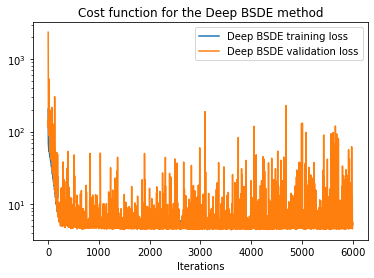

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot( modelfit.history["loss"], label='Deep BSDE training loss',
       zorder=1)
ax.plot( modelfit.history["val_loss"], label = 'Deep BSDE validation loss',zorder=2)
ax.legend(loc='best')
plt.yscale('log')
ax.set_title("Cost function for the Deep BSDE method")
plt.xlabel("Iterations")
plt.savefig("cost_function_bss.png",dpi=200)

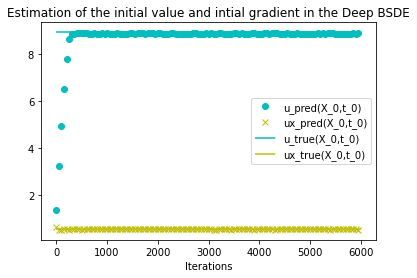

In [18]:
fig, ax = plt.subplots()
ax.plot( [savingepoch*list(range(len(u_pred_0)))[i] for i in range(len(u_pred_0))], u_pred_0, 'co', label = 'u_pred(X_0,t_0)' )
ax.plot( [savingepoch*list(range(len(u_pred_0)))[i] for i in range(len(u_pred_0))], ux_pred_0, 'yx', label = 'ux_pred(X_0,t_0)')
ax.hlines(u_true_fun(xi,t0),0,len(u_pred_0)*savingepoch,'c', label = 'u_true(X_0,t_0)')
ax.hlines(ux_true_fun(xi,t0),0,len(ux_pred_0)*savingepoch,'y', label = 'ux_true(X_0,t_0)')
ax.legend(loc="best")
plt.xlabel("Iterations")
ax.set_title("Estimation of the initial value and intial gradient in the Deep BSDE")
plt.savefig("estimation_u0_ux0_bss.png",dpi=200)

In [19]:
#Now we will use a custom callback to save the predicted values of u(X_i, t_i) and ux(X_i, t_i) 
#Note that X_i depend on the given path, so we will only save them for K random paths
K = 2*10
#We will take the first K random paths, which we will denote as (X^k_i) i = 0 ... n; k = 0 ... K - 1
#These values will be saved for each epoch of the model training.
#Therefore:
#u_pred[k][i] = prediction of u(X^k_i, t_i) at training end
#ux_pred[k][i] = prediction of ux(X^k_i, t_i) at epoch j
#u_pred must be K * (N+1) and u_pred must be K * N
u_pred  = [[None]*(N+1) for _ in range(K)]
ux_pred = [[None]*(N) for _ in range(K)]

#We will take the first K/2 random paths from the training set
for k in range(int(K/2)):  
    u_pred[k][0] = modelfit.model.get_layer("initialforwarditeration").theta.numpy() 
    ux_pred[k][0] = modelfit.model.get_layer("initialforwarditeration").thetax.numpy() 

    #Now we save the values of u_pred(X^k_i,t_i)
    #To obtain the first value, we take the output of "initialforwarditeration"
    extractor = keras.Model(inputs = modelfit.model.inputs, outputs = modelfit.model.get_layer("initialforwarditeration").output)
    u_pred[k][1] = extractor(traininput)[k].numpy() 
    #To obtain the values for i = 2...N-1, we evaluate the layers at the end of each subnetwork, 
    #which we have named "u_output_layer_i" and "ux_output_layer_i"
    for i in range(2,N):
        extractor = keras.Model(inputs = modelfit.model.inputs, outputs = modelfit.model.get_layer("u_output_layer_" + str(i)).output)
        u_pred[k][i] = extractor(traininput)[k].numpy() 
    #The last value of u_pred is the output of the network
    u_pred[k][N] = model(traininput)[k].numpy() 

    #In the case for ux, we don't have a value for ux(X_N,t_N), 
    #so we only take i = 1 ... N-1
    for i in range(1,N):
        extractor = keras.Model(inputs = modelfit.model.inputs, outputs = modelfit.model.get_layer("ux_output_layer_" + str(i)).output)
        ux_pred[k][i] = extractor(traininput)[k].numpy()

#We will take the other K/2 random paths from the validation set
for k in range(1,int(K/2)+1):  
    u_pred[-k][0] = modelfit.model.get_layer("initialforwarditeration").theta.numpy() 
    ux_pred[-k][0] = modelfit.model.get_layer("initialforwarditeration").thetax.numpy() 

    #Now we save the values of u_pred(X^k_i,t_i)
    #To obtain the first value, we take the output of "initialforwarditeration"
    extractor = keras.Model(inputs = modelfit.model.inputs, outputs = modelfit.model.get_layer("initialforwarditeration").output)
    u_pred[-k][1] = extractor(valinput)[-k].numpy() 
    #To obtain the values for i = 2...N-1, we evaluate the layers at the end of each subnetwork, 
    #which we have named "u_output_layer_i" and "ux_output_layer_i"
    for i in range(2,N):
        extractor = keras.Model(inputs = modelfit.model.inputs, outputs = modelfit.model.get_layer("u_output_layer_" + str(i)).output)
        u_pred[-k][i] = extractor(valinput)[-k].numpy() 
    #The last value of u_pred is the output of the network
    u_pred[-k][N] = modelfit.model(valinput)[-k].numpy() 

    #In the case for ux, we don't have a value for ux(X_N,t_N), 
    #so we only take i = 1 ... N-1
    for i in range(1,N):
        extractor = keras.Model(inputs = modelfit.model.inputs, outputs = modelfit.model.get_layer("ux_output_layer_" + str(i)).output)
        ux_pred[-k][i] = extractor(valinput)[-k].numpy() 

C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/E) + (r + 1/2*sigmabs**2)*(T-t))/(sigmabs*(T-t)**(1/2))
C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:29: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/E) + (r - 1/2*sigmabs**2)*(T-t))/(sigmabs*(T-t)**(1/2))
C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/E) + (r + 1/2*sigmabs**2)*(T-t))/(sigmabs*(T-t)**(1/2))
C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:29: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/E) + (r - 1/2*sigmabs**2)*(T-t))/(sigmabs*(T-t)**(1/2))
C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:26: RuntimeWarning: divide by zero en

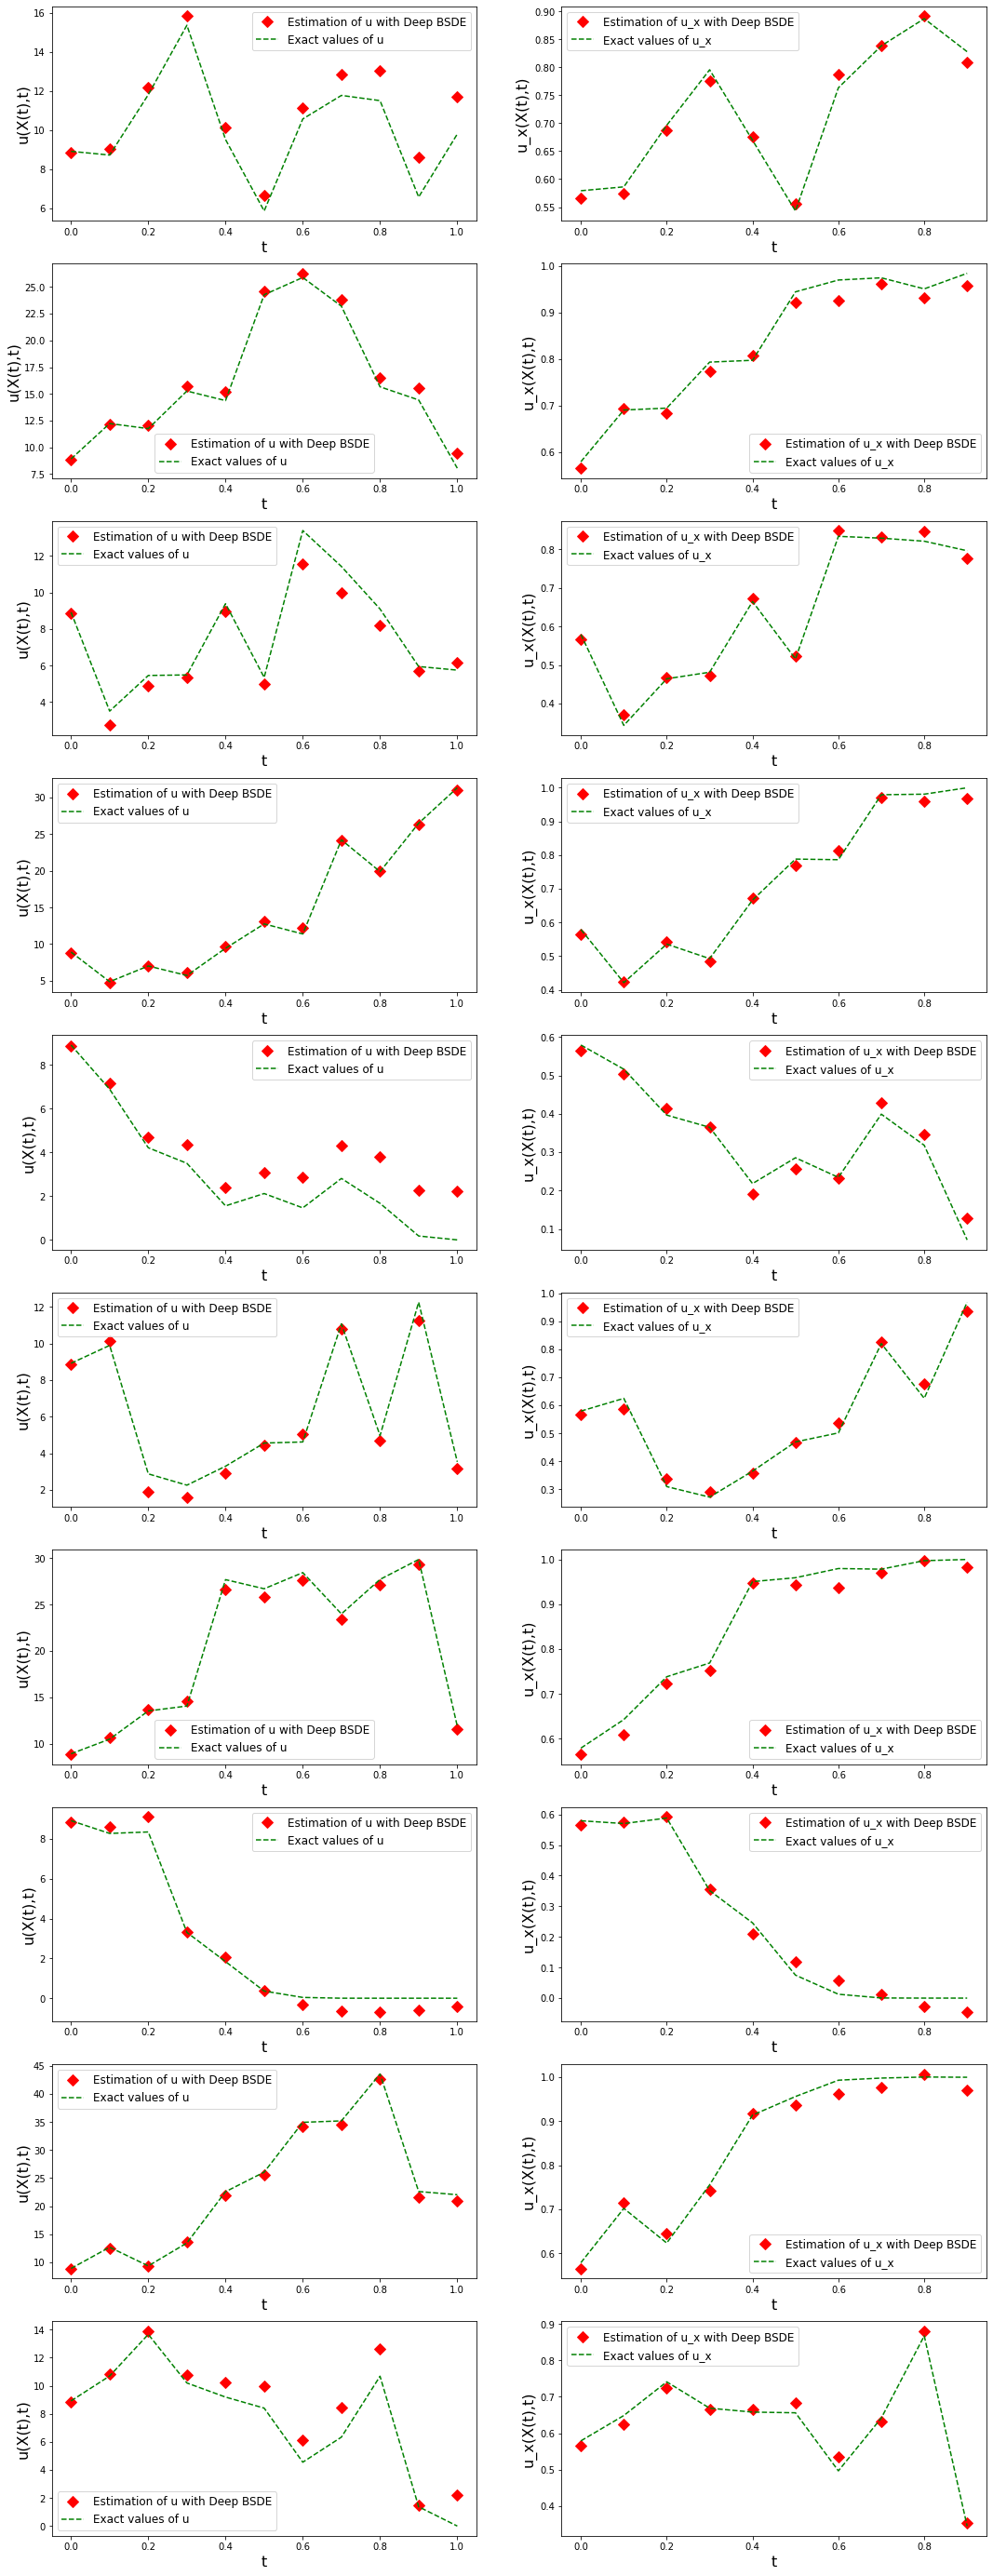

In [20]:
#Estimation of paths in the training set
Indices = list(range(int(K/2)))
l = len(Indices)
fig, axs = plt.subplots(l,2, figsize = (18,5*l))
t = np.linspace(t0,T,N+1)
for k in range(l):
    axs[k,0].plot( t, [u_pred[Indices[k]][i] for i in range(N+1)] ,
                  'rD', label = 'Estimation of u with Deep BSDE', markersize = 8 )
    axs[k,0].plot( t, u_true_fun(X[Indices[k]], t), 'g--', label = 'Exact values of u')
    axs[k,0].legend(loc='best',fontsize=12)
    axs[k,1].plot( t[0:N], [ux_pred[Indices[k]][i] for i in range(N)] , 'rD', 
                  label = 'Estimation of u_x with Deep BSDE', markersize = 8 )
    axs[k,1].plot( t[0:N], ux_true_fun(X[Indices[k],0:N], t[0:N]), 'g--', label = 'Exact values of u_x')
    axs[k,1].legend(loc='best',fontsize=12)
    axs[k,0].set_xlabel('t',fontsize=16)
    axs[k,1].set_xlabel('t',fontsize=16)
    axs[k,0].set_ylabel('u(X(t),t)',fontsize=16)
    axs[k,1].set_ylabel('u_x(X(t),t)',fontsize=16)
plt.savefig("path_prediction_train_bss.png",dpi=400,bbox_inches="tight")

#The error messages appear due to the expression of the Black-Scholes formula (a division by 0 appears at terminal time), but they can be safely ignored

C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/E) + (r + 1/2*sigmabs**2)*(T-t))/(sigmabs*(T-t)**(1/2))
C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:29: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/E) + (r - 1/2*sigmabs**2)*(T-t))/(sigmabs*(T-t)**(1/2))
C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/E) + (r + 1/2*sigmabs**2)*(T-t))/(sigmabs*(T-t)**(1/2))
C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:29: RuntimeWarning: divide by zero encountered in true_divide
  return (np.log(x/E) + (r - 1/2*sigmabs**2)*(T-t))/(sigmabs*(T-t)**(1/2))
C:\Users\buitr\Documents\python\TFG_math\github\initialize_deepbsde_BS_standard.py:26: RuntimeWarning: divide by zero en

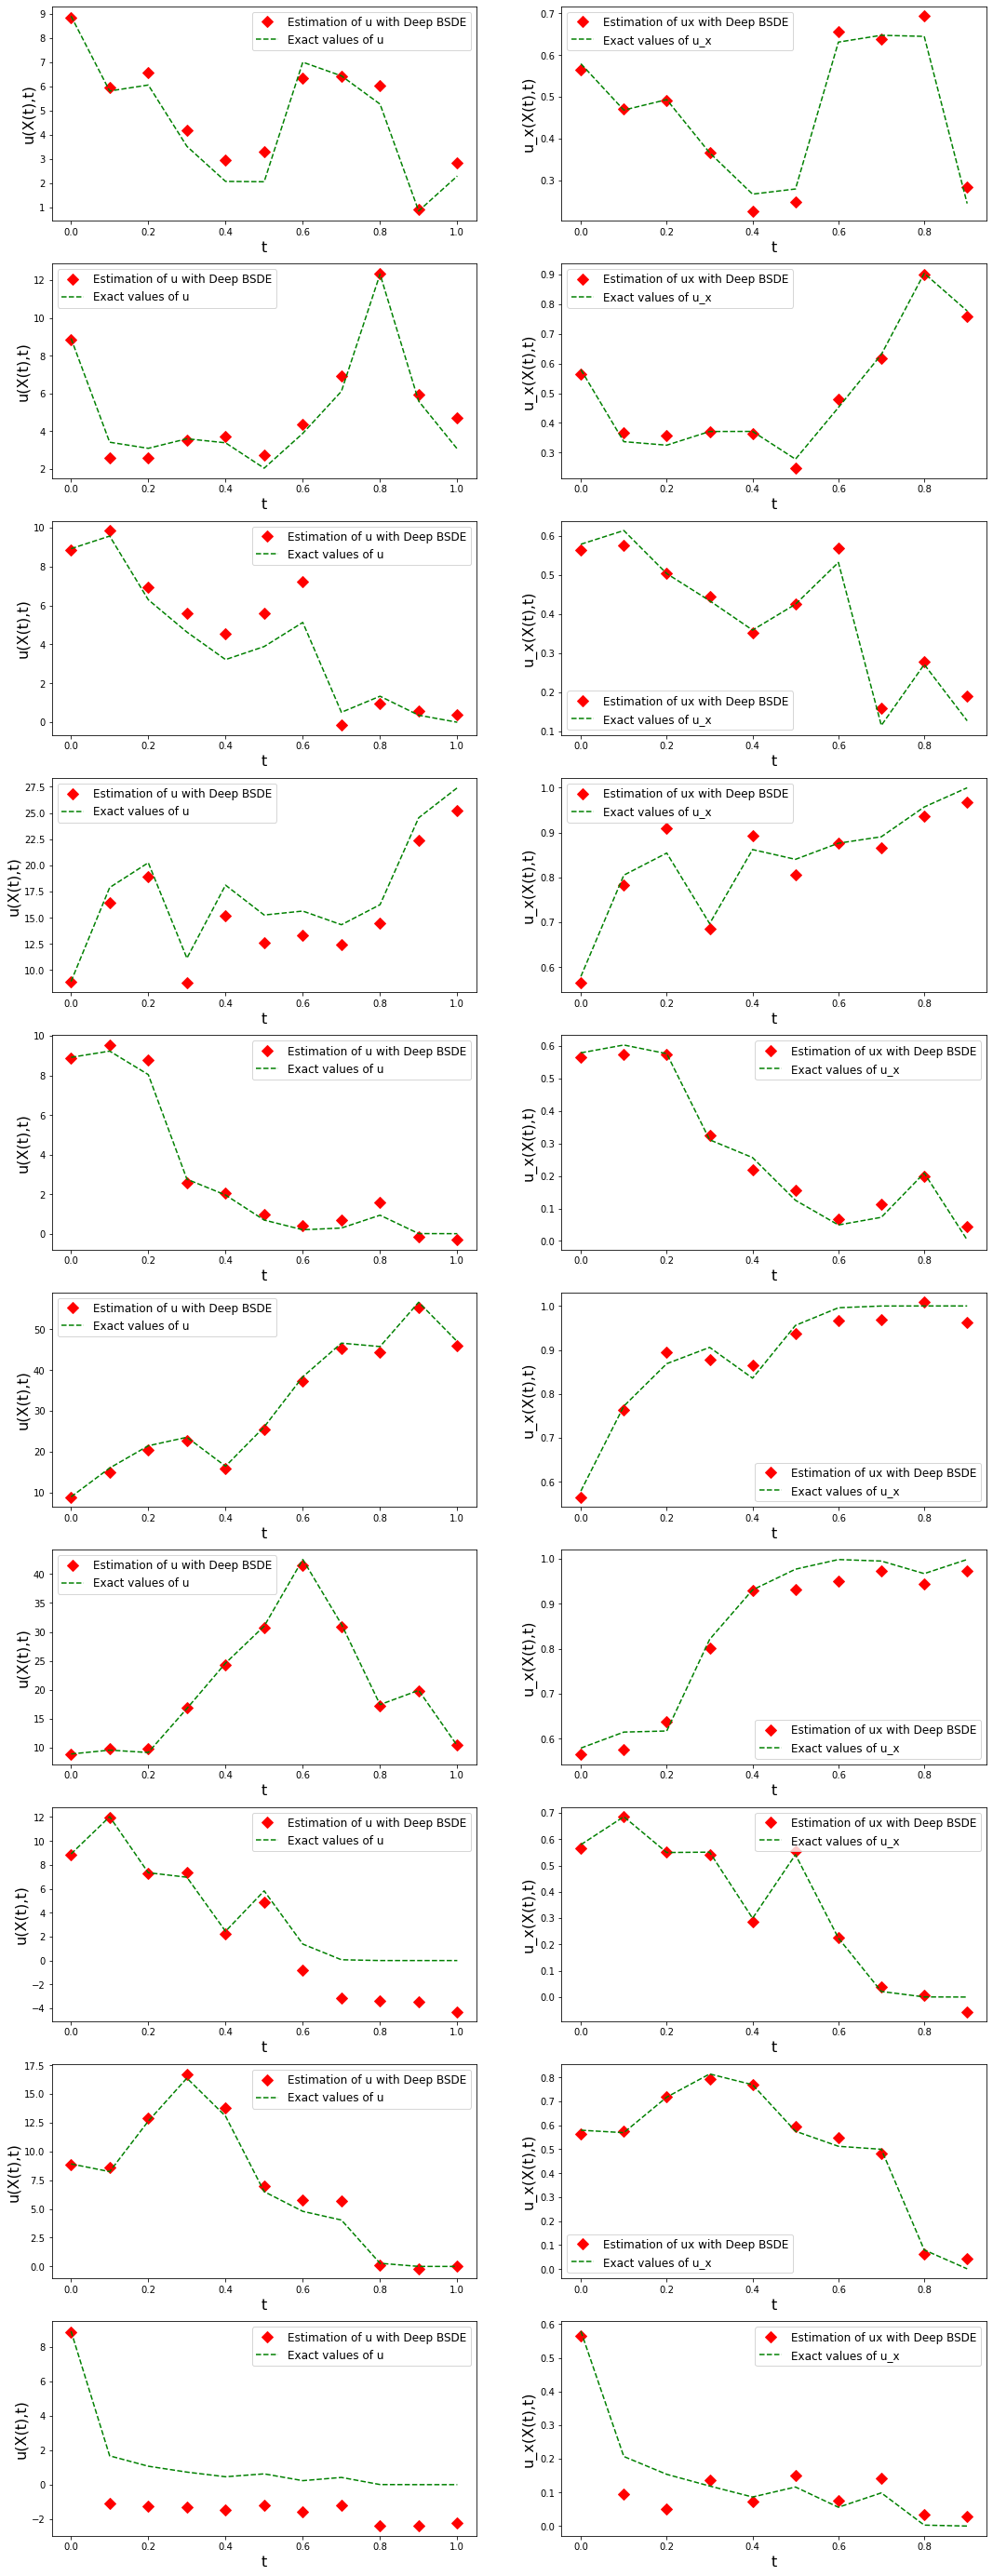

In [21]:
#Estimation of paths in the validation set
Indices = list(range(int(K/2)))
l = len(Indices)
Indices = [ -Indices[i]-1 for i in range(l)]
fig, axs = plt.subplots(l,2, figsize = (18,5*l))
t = np.linspace(t0,T,N+1)
for k in range(l):
    axs[k,0].plot( t, [u_pred[Indices[k]][i] for i in range(N+1)] ,
                  'rD', label = 'Estimation of u with Deep BSDE', markersize = 8 )
    axs[k,0].plot( t, u_true_fun(X[Indices[k]], t), 'g--', label = 'Exact values of u')
    axs[k,0].legend(loc='best',fontsize=12)
    axs[k,1].plot( t[0:N], [ux_pred[Indices[k]][i] for i in range(N)] , 'rD', 
                  label = 'Estimation of ux with Deep BSDE', markersize = 8 )
    axs[k,1].plot( t[0:N], ux_true_fun(X[Indices[k],0:N], t[0:N]), 'g--', label = 'Exact values of u_x')
    axs[k,1].legend(loc='best',fontsize=12)
    axs[k,0].set_xlabel('t',fontsize=16)
    axs[k,1].set_xlabel('t',fontsize=16)
    axs[k,0].set_ylabel('u(X(t),t)',fontsize=16)
    axs[k,1].set_ylabel('u_x(X(t),t)',fontsize=16)
plt.savefig("path_prediction_val_bss.png",dpi=400,bbox_inches="tight")

In [22]:
#Now, we will compare the real function ux_true with our estimation of it ux_pred, for values of x
# around xi
#ux_pred(x)[i] = ux_pred(x,t_{i+1}) i = 0, ..., N-2
def ux_pred_fun(x):
    lenx = len(x)
    V = [None]*(N-1)
    for i in range(N-1):
        extractor = keras.Model(inputs = modelfit.model.get_layer("X_"+str(i+1)).input,
                        outputs = modelfit.model.get_layer("ux_output_layer_"+str(i+1)).output)
        V[i] = extractor(tf.constant(x,shape=(len(x),1))).numpy()
        V[i] = np.squeeze(V[i])
    return V

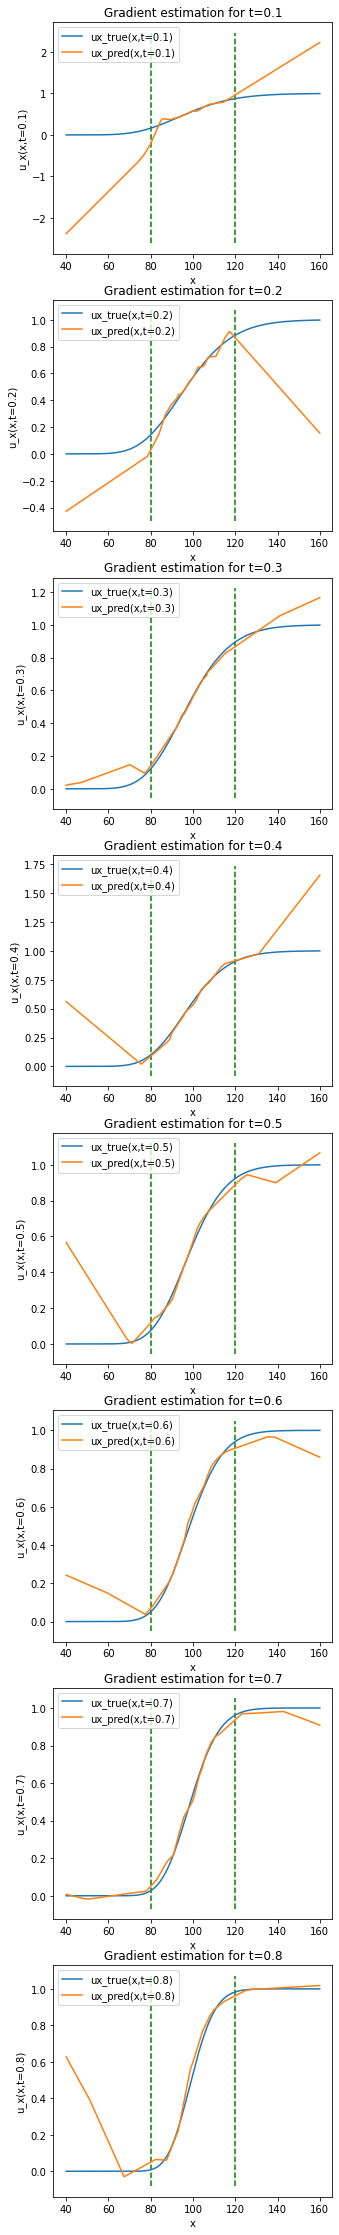

In [23]:
#Now we graph the estimation of ux(·,t_i)
sigma0 = xi*sigmabs
x = np.linspace(xi-3*sigma0,xi+3*sigma0,1000)
t = np.linspace(t0,T,N+1)
Ind = np.linspace(1,N-2,N-2,dtype="int")
fig, axs = plt.subplots(len(Ind), figsize=(5,5*len(Ind)))
j = 0
ux_pred_fun_x = ux_pred_fun(x)
for i in Ind:
    axs[j].plot( x, ux_true_fun(x,t[i]), label="ux_true(x,t=" + str(round(t[i],2)) + ")")
    axs[j].plot( x, ux_pred_fun_x[i-1], label="ux_pred(x,t=" + str(round(t[i],2)) + ")" )
    minylim = axs[j].get_ylim()[0]
    maxylim = axs[j].get_ylim()[1]
    axs[j].vlines( xi+sigma0, ymin = minylim, ymax = maxylim,
                  colors="green",linestyles="dashed")
    axs[j].vlines( xi-sigma0, ymin = minylim, ymax = maxylim,
                  colors="green",linestyles="dashed")
    axs[j].legend(loc="best")
    axs[j].set_title("Gradient estimation for t=" + str(round(t[i],2)) )
    axs[j].set_xlabel("x")
    axs[j].set_ylabel("u_x(x,t=" + str(round(t[i],2)) + ")")
    j = j+1

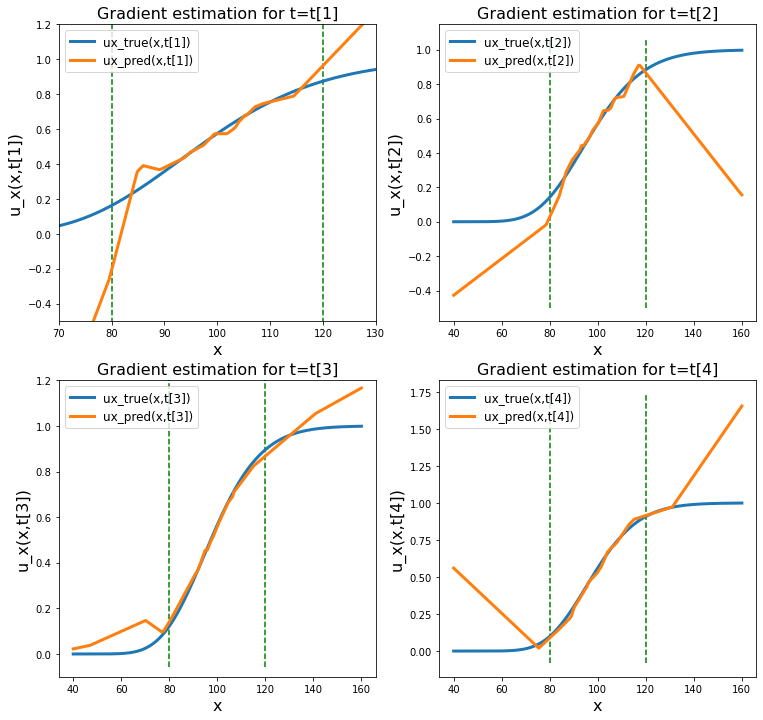

In [30]:
fig, axs = plt.subplots(2,2, figsize=(12.5,12))
i = Ind[0]
axs[0,0].plot( x, ux_true_fun(x,t[i]), label="ux_true(x,t[" + str(i) + "])", linewidth= 3 )
axs[0,0].plot( x, ux_pred_fun_x[i-1], label="ux_pred(x,t[" + str(i) + "])", linewidth= 3 )
minylim = axs[0,0].get_ylim()[0]
maxylim = axs[0,0].get_ylim()[1]
axs[0,0].vlines( xi+sigma0, ymin = minylim, ymax = maxylim,
              colors="green",linestyles="dashed")
axs[0,0].vlines( xi-sigma0, ymin = minylim, ymax = maxylim,
              colors="green",linestyles="dashed")
axs[0,0].legend(loc="best",fontsize=12)
axs[0,0].set_xlim(70,130) #!!!
axs[0,0].set_ylim(-0.5,1.2) #!!!
axs[0,0].set_title("Gradient estimation for t=t[" + str(i) + "]",fontsize=16)
axs[0,0].set_xlabel("x",fontsize=16)
axs[0,0].set_ylabel("u_x(x,t[" + str(i) + "])",fontsize=16)

i = Ind[1]
axs[0,1].plot( x, ux_true_fun(x,t[i]), label="ux_true(x,t[" + str(i) + "])", linewidth= 3 )
axs[0,1].plot( x, ux_pred_fun_x[i-1], label="ux_pred(x,t[" + str(i) + "])", linewidth= 3 )
minylim = axs[0,1].get_ylim()[0]
maxylim = axs[0,1].get_ylim()[1]
axs[0,1].vlines( xi+sigma0, ymin = minylim, ymax = maxylim,
              colors="green",linestyles="dashed")
axs[0,1].vlines( xi-sigma0, ymin = minylim, ymax = maxylim,
              colors="green",linestyles="dashed")
axs[0,1].legend(loc="best",fontsize=12)
axs[0,1].set_title("Gradient estimation for t=t[" + str(i) + "]",fontsize=16)
axs[0,1].set_xlabel("x",fontsize=16)
axs[0,1].set_ylabel("u_x(x,t[" + str(i) + "])",fontsize=16)

i = Ind[2]
axs[1,0].plot( x, ux_true_fun(x,t[i]), label="ux_true(x,t[" + str(i) + "])", linewidth= 3)
axs[1,0].plot( x, ux_pred_fun_x[i-1], label="ux_pred(x,t[" + str(i) + "])", linewidth= 3 )
minylim = axs[1,0].get_ylim()[0]
maxylim = axs[1,0].get_ylim()[1]
axs[1,0].vlines( xi+sigma0, ymin = minylim, ymax = maxylim,
              colors="green",linestyles="dashed")
axs[1,0].vlines( xi-sigma0, ymin = minylim, ymax = maxylim,
              colors="green",linestyles="dashed")
axs[1,0].legend(loc="best",fontsize=12)
axs[1,0].set_ylim(-0.1,1.2) #!!!
axs[1,0].set_title("Gradient estimation for t=t[" + str(i) + "]",fontsize=16)
axs[1,0].set_xlabel("x",fontsize=16)
axs[1,0].set_ylabel("u_x(x,t[" + str(i) + "])",fontsize=16)

i = Ind[3]
axs[1,1].plot( x, ux_true_fun(x,t[i]), label="ux_true(x,t[" + str(i) + "])", linewidth= 3 )
axs[1,1].plot( x, ux_pred_fun_x[i-1], label="ux_pred(x,t[" + str(i) + "])", linewidth= 3 )
minylim = axs[1,1].get_ylim()[0]
maxylim = axs[1,1].get_ylim()[1]
axs[1,1].vlines( xi+sigma0, ymin = minylim, ymax = maxylim,
              colors="green",linestyles="dashed")
axs[1,1].vlines( xi-sigma0, ymin = minylim, ymax = maxylim,
              colors="green",linestyles="dashed")
axs[1,1].legend(loc="best",fontsize=12)
axs[1,1].set_title("Gradient estimation for t=t[" + str(i) + "]",fontsize=16)
axs[1,1].set_xlabel("x",fontsize=16)
axs[1,1].set_ylabel("u_x(x,t[" + str(i) + "])",fontsize=16)


plt.savefig("ux_estimation_selection_bss.png",dpi=200,bbox_inches="tight")

In [24]:
x1 = np.linspace(xi-sigma(xi,t0),xi+sigma(xi,t0),1000)
ux_pred_x1 = ux_pred_fun(x1)
mse_pred_x1 = [ ( np.mean( (ux_true_fun(x1,t[i+1])-ux_pred_x1[i])**2 ) )**(1/2) for i in range(N-1)]
var_x1 = [ ( np.var( ux_true_fun(x1,t[i+1]) ) )**(1/2) for i in range(N-1)]
x2 = np.linspace(xi-2*sigma(xi,t0),xi+2*sigma(xi,t0),2000)
ux_pred_x2 = ux_pred_fun(x2)
mse_pred_x2 = [ ( np.mean( (ux_true_fun(x2,t[i+1])-ux_pred_x2[i])**2 ) )**(1/2) for i in range(N-1)]
var_x2 = [ ( np.var( ux_true_fun(x2,t[i+1]) ) )**(1/2) for i in range(N-1)]

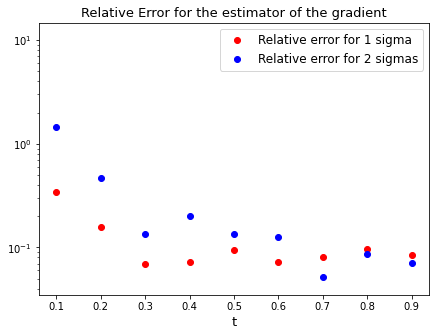

In [25]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

ax.plot(t[1:N],[mse_pred_x1[i]/var_x1[i] for i in range(N-1)],'ro',label="Relative error for 1 sigma")
ax.set_title("Relative Error for the estimator of the gradient",fontsize=13)
ax.plot(t[1:N],[mse_pred_x2[i]/var_x2[i] for i in range(N-1)],'bo',label="Relative error for 2 sigmas")
ax.legend(loc="best",fontsize=12)
ax.set_ylim(min([mse_pred_x1[i]/var_x1[i] for i in range(N-1)])/2,max([mse_pred_x2[i]/var_x2[i] for i in range(N-1)])*10)
ax.set_xlabel('t',fontsize=13)
plt.yscale('log')
plt.savefig("ux_estimation_error_relative_bss.png",dpi=200,bbox_inches="tight")

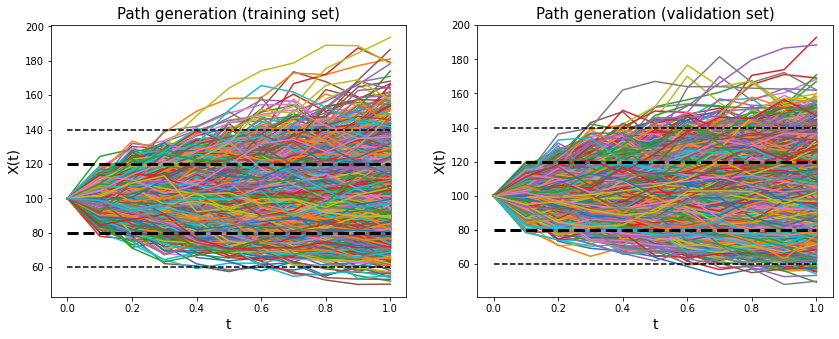

In [26]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
ax = axs[0]
for m in range(int(M/2)):
    ax.plot(t,X[m,:],zorder=1)
ax.hlines(xi-sigma0,t0,T,'k',linewidth=3,linestyles="dashed",zorder=2)
ax.hlines(xi+sigma0,t0,T,'k',linewidth=3,linestyles="dashed",zorder=2)
ax.hlines(xi-2*sigma0,t0,T,'k',linewidth=1.5,linestyles="dashed",zorder=2)
ax.hlines(xi+2*sigma0,t0,T,'k',linewidth=1.5,linestyles="dashed",zorder=2)
ax.set_xlabel('t',fontsize=14)
ax.set_ylabel('X(t)',fontsize=14)
ax.set_title('Path generation (training set)',fontsize=15)

ax = axs[1]
for m in range(int(M/2)+1,M):
    ax.plot(t,X[m,:],zorder=1)
ax.hlines(xi-sigma0,t0,T,'k',linewidth=3,linestyles="dashed",zorder=2)
ax.hlines(xi+sigma0,t0,T,'k',linewidth=3,linestyles="dashed",zorder=2)
ax.hlines(xi-2*sigma0,t0,T,'k',linewidth=1.5,linestyles="dashed",zorder=2)
ax.hlines(xi+2*sigma0,t0,T,'k',linewidth=1.5,linestyles="dashed",zorder=2)
ax.set_xlabel('t',fontsize=14)
ax.set_ylabel('X(t)',fontsize=14)
ax.set_title('Path generation (validation set)',fontsize=15)
plt.savefig("pathgeneration_bss_train_val_1.png",dpi=200,bbox_inches="tight")